In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.mlab
import scipy.io.wavfile
import scipy
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset.slice_file_name = 'audio/fold' + dataset.fold.astype(str) + '/' + dataset.slice_file_name
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
1153,audio/fold7/127443-4-0-0.wav,127443,115.015008,119.015008,1,7,4,drilling
4610,audio/fold9/187075-5-0-6.wav,187075,6.446779,10.446779,2,9,5,engine_idling
4873,audio/fold4/192382-2-0-18.wav,192382,9.000000,13.000000,1,4,2,children_playing
1118,audio/fold8/125678-7-3-1.wav,125678,72.677418,76.677418,1,8,7,jackhammer
6860,audio/fold1/57320-0-0-22.wav,57320,11.000000,15.000000,2,1,0,air_conditioner


In [3]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [4]:
# define our global variables
learning_rate = 0.001
sound_dimension = [64, 512]
batch_size = 128
epoch = 20

In [5]:
def processAudio(audio_file):
    rate, data = scipy.io.wavfile.read(audio_file)
    try:
        if data.shape[1]:
            data = np.mean(data, axis = 1)
    except:
        pass
    audio = matplotlib.mlab.specgram(data)[0]
    audio = scipy.misc.imresize(audio, sound_dimension)
    return np.expand_dims(audio, axis = 2)

In [6]:
class Model:

    def __init__(self, size_output):
        self.X = tf.placeholder('float', [None, sound_dimension[0], sound_dimension[1], 1])
        self.Y = tf.placeholder('float', [None, size_output])

        def conv_layer(x, conv, out_shape, name, stride = 1):
            w = tf.Variable(tf.truncated_normal([conv, conv, int(x.shape[3]), out_shape]), name = name + '_w')
            b = tf.Variable(tf.truncated_normal([out_shape], stddev = 0.01), name = name + '_b')
            return tf.nn.conv2d(x, w, [1, stride, stride, 1], padding = 'SAME') + b
        
        def fully_connected(x, out_shape, name):
            w = tf.Variable(tf.truncated_normal([int(x.shape[1]), out_shape]), name = name + '_fc_w')
            b = tf.Variable(tf.truncated_normal([out_shape], stddev = 0.01), name = name + '_fc_b')
            return tf.matmul(x, w) + b

        def pooling(x, k = 2, stride = 2):
            return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, stride, stride, 1], padding = 'SAME')

        with tf.name_scope("conv5-16"):
            conv1 = tf.nn.relu(conv_layer(self.X, 5, 16, '16'))

        with tf.name_scope("maxpool-1"):
            pooling1 = pooling(conv1)

        with tf.name_scope("conv5-32"):
            conv2 = tf.nn.relu(conv_layer(pooling1, 5, 16, '16'))

        with tf.name_scope("maxpool-2"):
            pooling2 = pooling(conv2)

        with tf.name_scope("conv5-64"):
            conv3 = tf.nn.relu(conv_layer(pooling2, 5, 64, '64'))

        with tf.name_scope("maxpool-3"):
            pooling3 = pooling(conv3)

        with tf.name_scope("conv5-128"):
            conv4 = tf.nn.relu(conv_layer(pooling3, 5, 128, '128'))

        with tf.name_scope("maxpool-4"):
            pooling4 = pooling(conv4)
        
        output_shape = int(pooling4.shape[1]) * int(pooling4.shape[2]) * int(pooling4.shape[3])
        
        with tf.name_scope("fc-512"):
            pooling4 = tf.reshape(pooling4, [-1, output_shape])
            fc1 = tf.nn.relu(fully_connected(pooling4, 512, '512'))

        with tf.name_scope("fc-128"):
            fc2 = tf.nn.relu(fully_connected(fc1, 128, '128'))

        with tf.name_scope("logits"):
            self.logits = fully_connected(fc2, size_output, 'logits')
            
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [7]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(no_classes)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [8]:
ACCURACY, LOST = [], []
for i in range(epoch):
    last = time.time()
    total_acc, total_loss = 0, 0
    for k in range(0, (train_dataset.shape[0] // batch_size) * batch_size, batch_size):
        batch_x, batch_y = [], []
        for n in range(batch_size):
            try:
                batch_x.append(processAudio(train_dataset.slice_file_name.iloc[k + n]))
                onehot = np.zeros((no_classes))
                onehot[train_dataset.classID.iloc[k + n]] = 1.0
                batch_y.append(onehot)
            except Exception as e:
                continue
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= (train_dataset.shape[0] // batch_size)
    total_acc /= (train_dataset.shape[0] // batch_size)
    ACCURACY.append(total_acc)
    LOST.append(total_loss)
    print('epoch: ', i + 1, 'avg loss: ', total_loss, 'avg acc: ', total_acc, 'avg time: ', (time.time() - last) / (train_dataset.shape[0] // batch_size))

('epoch: ', 1, 'avg loss: ', 355989466.07407409, 'avg acc: ', 0.26660441289897319, 'avg time: ', 1.7140804617493242)
('epoch: ', 2, 'avg loss: ', 108546171.55555555, 'avg acc: ', 0.38289101642590984, 'avg time: ', 1.4117632044686212)
('epoch: ', 3, 'avg loss: ', 66213184.296296299, 'avg acc: ', 0.44299414643534907, 'avg time: ', 1.409248259332445)
('epoch: ', 4, 'avg loss: ', 46724492.703703701, 'avg acc: ', 0.50952830027650908, 'avg time: ', 1.4082880020141602)
('epoch: ', 5, 'avg loss: ', 35683346.962962963, 'avg acc: ', 0.55218905044926536, 'avg time: ', 1.4053929072839242)
('epoch: ', 6, 'avg loss: ', 27949425.629629631, 'avg acc: ', 0.5803841805016553, 'avg time: ', 1.4093971649805705)
('epoch: ', 7, 'avg loss: ', 22625920.666666668, 'avg acc: ', 0.61942265486275705, 'avg time: ', 1.40776057155044)
('epoch: ', 8, 'avg loss: ', 18664258.462962963, 'avg acc: ', 0.64854848715994096, 'avg time: ', 1.4118617993813973)
('epoch: ', 9, 'avg loss: ', 15714998.703703703, 'avg acc: ', 0.6710

In [9]:
batch_x, batch_y, labels = [], [], []
for n in range(128):
    try:
        batch_x.append(processAudio(test_dataset.slice_file_name.iloc[n]))
        onehot = np.zeros((no_classes))
        onehot[test_dataset.classID.iloc[n]] = 1.0
        batch_y.append(onehot)
        labels.append(test_dataset.classID.iloc[n])
    except Exception as e:
        continue
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
print 'testing accuracy: ' + str(acc)
print(metrics.classification_report(labels, logits, target_names = np.unique(unique_sound)))

testing accuracy: 0.4
                  precision    recall  f1-score   support

 air_conditioner       0.40      0.20      0.27        10
        car_horn       0.29      0.33      0.31         6
children_playing       0.16      0.33      0.21         9
        dog_bark       0.36      0.31      0.33        16
        drilling       0.50      0.55      0.52        11
   engine_idling       0.56      0.56      0.56         9
        gun_shot       0.33      0.33      0.33         3
      jackhammer       0.57      0.44      0.50         9
           siren       0.46      0.67      0.55         9
    street_music       0.67      0.31      0.42        13

     avg / total       0.45      0.40      0.40        95



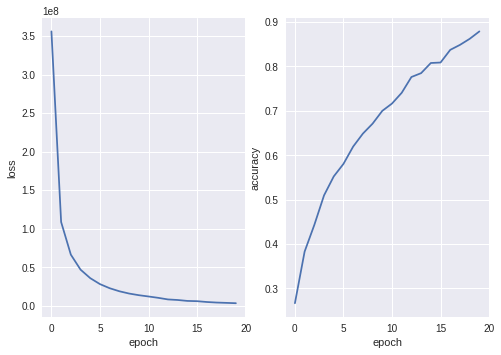

In [10]:
EPOCH = np.arange(len(LOST))
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()